In [276]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss

# Dataframe for QQQ holdings and their weight

In [277]:
df_QQQ = pd.read_csv(r'C:\Users\ronak\OneDrive\Desktop\stock-prediction-capstone\QQQ-holdings.csv')

In [278]:
df_QQQ

,Holding,Symbol,Weighting
0,Apple Inc.,AAPL,11.01%
1,Microsoft Corporation,MSFT,10.36%
2,"Amazon.com, Inc.",AMZN,7.74%
3,Tesla Inc,TSLA,4.7%
4,Alphabet Inc. Class C,GOOG,4.12%
...,...,...,...
98,Trip.com Group Ltd. Sponsored ADR,TCOM,0.12%
99,Check Point Software Technologies Ltd.,CHKP,0.11%
100,Incyte Corporation,INCY,0.1%
101,Fox Corporation Class A,FOXA,0.1%


# Getting individual stock data 

In [279]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2009-01-31', end='2021-01-31', interval = "1d")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)

    return df

In [280]:
aapl = get_finance_data('AAPL')

In [281]:
aapl

,Open,High,Low,Close,Volume
Date,,,,,
2009-02-02,2.732240,2.821168,2.726107,2.806142,558247200
2009-02-03,2.818715,2.863486,2.768425,2.851220,599309200
2009-02-04,2.858580,2.951494,2.854900,2.868698,808421600
2009-02-05,2.844780,2.982158,2.840180,2.957933,749246400
2009-02-06,2.975106,3.066488,2.974493,3.057902,687209600
...,...,...,...,...,...
2021-01-25,142.400956,144.411498,135.901478,142.251648,157611700
2021-01-26,142.928454,143.625177,140.708872,142.490509,98390600
2021-01-27,142.759249,143.625191,139.753383,141.395660,140843800


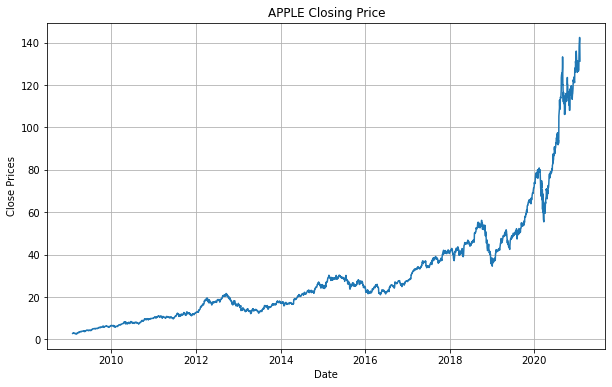

In [282]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(aapl['Close'])
plt.title('APPLE Closing Price')
plt.show()

<AxesSubplot:ylabel='Density'>

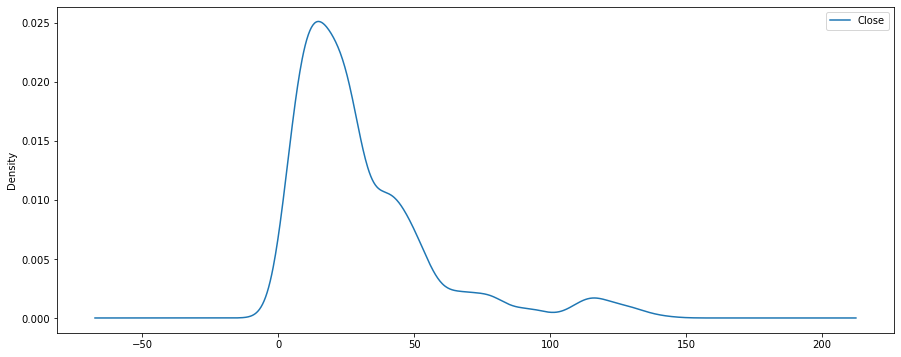

In [283]:
#Distribution of the dataset
aapl_close = aapl[['Close']]
aapl_close.plot(kind='kde')

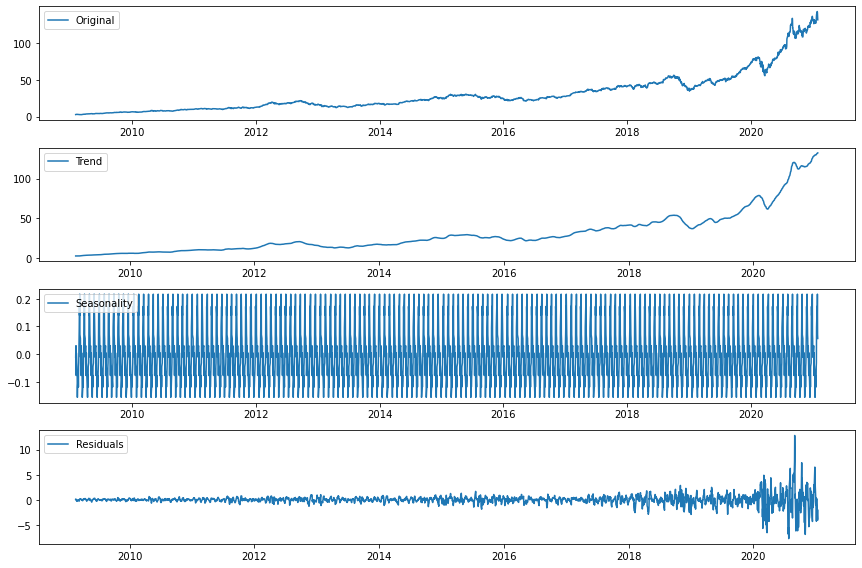

In [284]:
decomposition = seasonal_decompose(aapl_close, period = 20)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(aapl_close, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

In [285]:
dftest = adfuller(aapl_close)
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                    3.126917
p-value                           1.000000
#Lags Used                       29.000000
Number of Observations Used    2990.000000
Critical Value (1%)              -3.432539
Critical Value (5%)              -2.862507
Critical Value (10%)             -2.567285
dtype: float64


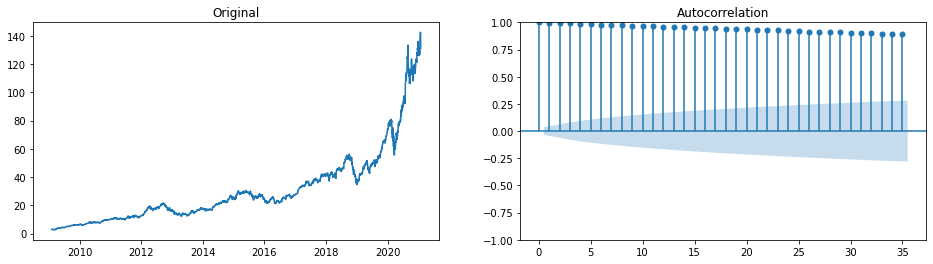

In [286]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(aapl_close);
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(aapl_close, ax=ax2);

## One difference

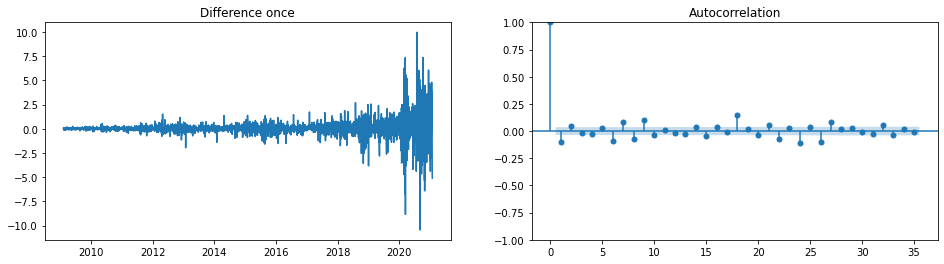

In [287]:
diff = aapl_close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff);
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

## Second Difference

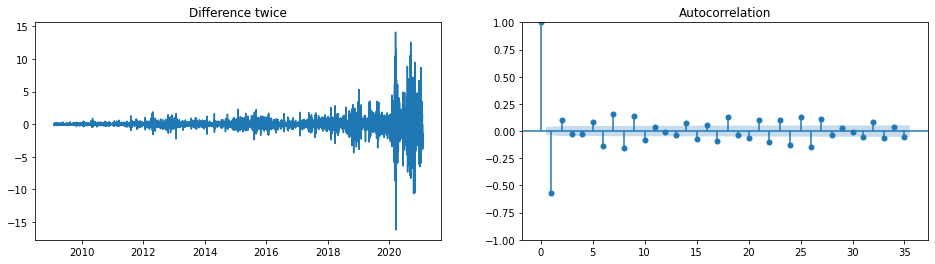

In [288]:
diff = aapl_close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff);
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2);

## PACF / P value

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


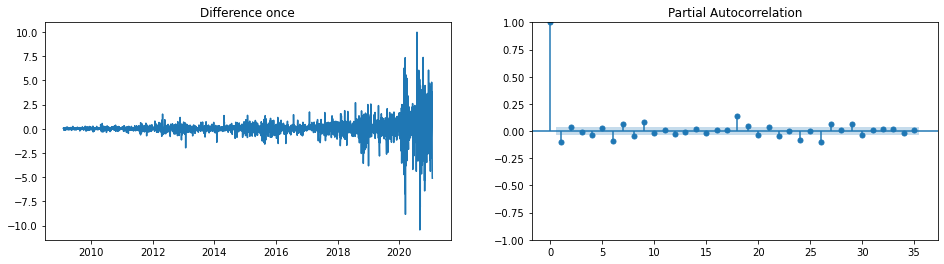

In [289]:
diff = aapl_close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff);
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

The lag bounces below at lag 6

## Q value

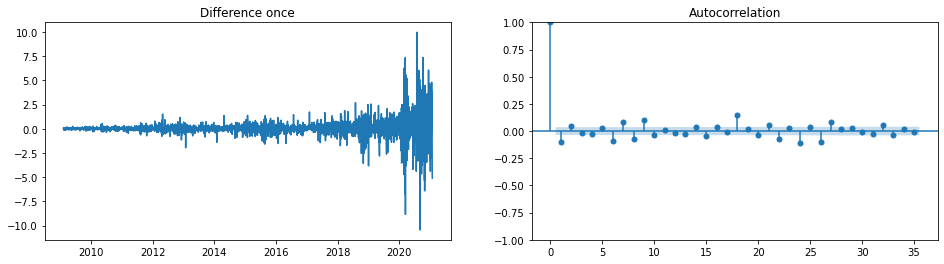

In [290]:
diff = aapl_close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff);
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

This will stay at 1

## Building FSM ARIMA

In [291]:
aapl_close.index = pd.DatetimeIndex(aapl_close.index).to_period('B')

In [292]:
# ARIMA Model
model = ARIMA(aapl_close, order=(0, 1, 3))
result = model.fit()

In [293]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3020
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -3922.030
Date:                Thu, 14 Oct 2021   AIC                           7852.059
Time:                        17:05:12   BIC                           7876.110
Sample:                    02-02-2009   HQIC                          7860.707
                         - 01-29-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0930      0.006    -15.339      0.000      -0.105      -0.081
ma.L2          0.0528      0.005     10.408      0.000       0.043       0.063
ma.L3         -0.0254      0.007     -3.753      0.0

In [294]:
pred = result.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=False)
pred_conf = pred.conf_int()

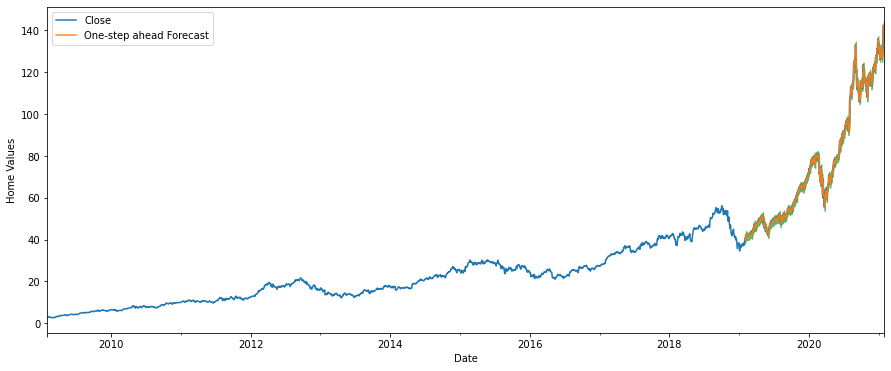

In [295]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = aapl_close.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Values')
plt.legend()

plt.show();

In [296]:
value_forecasted = pred.predicted_mean
value_truth = aapl_close['Close']['2019-01-31':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 1.98


## Forecasting

In [297]:
n = int(len(aapl_close) * 0.8)
train = aapl_close[:n]
test = aapl_close[n:]

In [310]:
# Get forecast 100 steps ahead in future
prediction = result.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

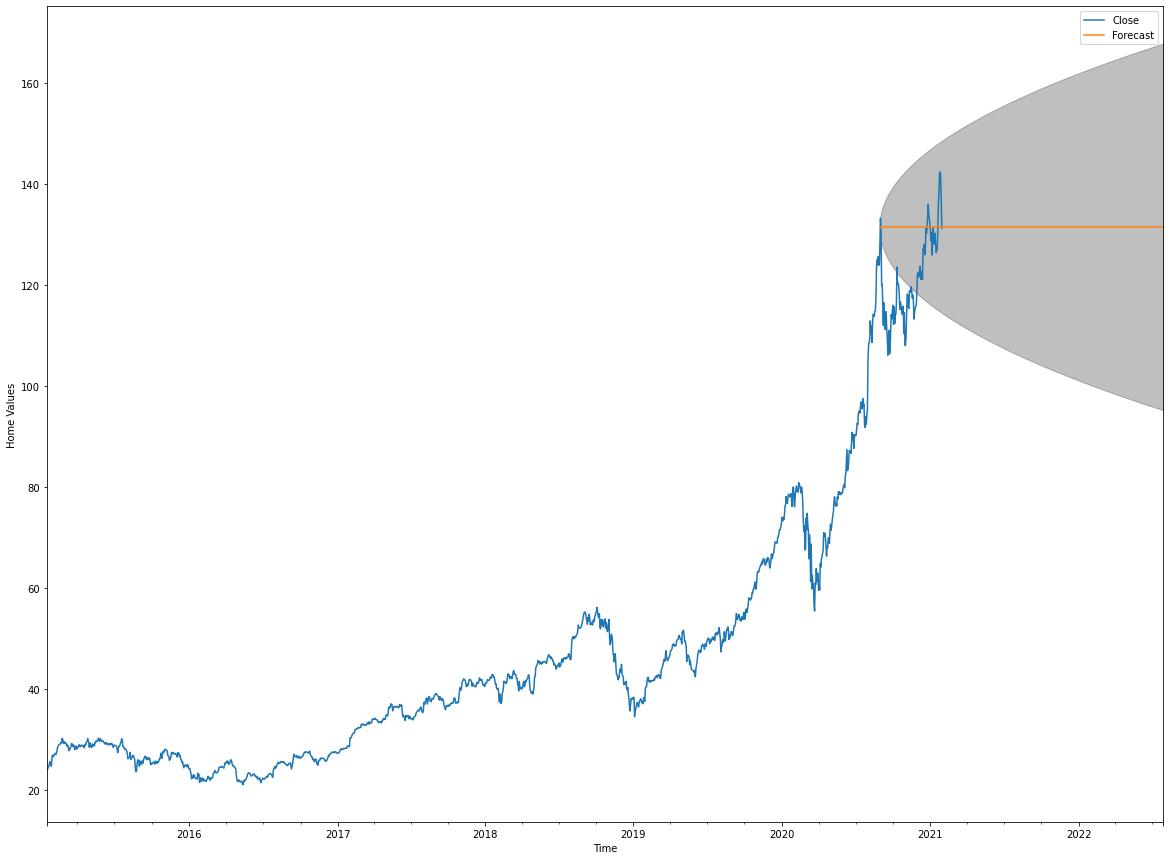

In [311]:
ax = aapl_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Time')
ax.set_ylabel('Home Values')
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.legend()
plt.show()